<a href="https://colab.research.google.com/github/Anya-Gupta-05/Music_Genre_Classification_using-CNN-and-LSTM/blob/main/Music_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎵 LSTM Model for Music Genre Classification

## 📌 Overview

This project aims to classify **music genres** using a **hybrid deep learning model**

- 🔁 **LSTM (Long Short-Term Memory Network)** to capture time-based audio features (MFCCs and more).
---

## 🧩 What is a Feature?

In machine learning, a **feature** is a piece of information extracted from raw data that helps a model make decisions.

In audio, features are numerical representations of **how the sound behaves** over time — like pitch, loudness, brightness, or rhythm.

---

## ⏱️ What is a Time Frame?

Audio signals are **continuous** over time, but we analyze them in small slices called **time frames** (e.g., 25 milliseconds).  
For each time frame, we extract a set of features.  
So a 30-second song becomes **many time frames**, each with their own feature values — forming a sequence.

---

## 🔍 Feature Set Used in This Project

### 1. **MFCC (Mel-Frequency Cepstral Coefficients)**
- Represents short-term sound texture as perceived by humans.
- Compact and effective.
- Extracted per time frame.
- 📐 Shape: `(time_steps, n_mfcc)` (e.g., `(130, 20)`)

### 2. **Delta MFCC (1st Derivative)**
- Measures the rate of change of MFCCs.
- Captures dynamics over time.

### 3. **Delta-Delta MFCC (2nd Derivative)**
- Measures how quickly the change is changing (acceleration).
- Adds more temporal sensitivity.

### 4. **Chroma Features** (Optional)
- Represents how much of each musical pitch class (C, D, E...) is present.
- Captures harmony and chords.

### 5. **Zero-Crossing Rate (ZCR)**
- Number of times the audio signal crosses zero amplitude.
- Helps identify noisiness or percussiveness.

### 6. **RMS Energy**
- Measures loudness of audio in each frame.

### 7. **Spectral Centroid**
- Indicates the "center" of frequencies.
- Higher value = brighter sound.

### 8. **Spectral Bandwidth / Rolloff** (Optional)
- Describe how spread out or focused the frequencies are.
---

## ⚙️ Technologies Used

- Python
- Librosa (for audio processing)
- TensorFlow / PyTorch (for deep learning)
- Matplotlib / Seaborn (for visualizations)
- Jupyter Notebooks

---



In [1]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten,
    LSTM, Dense, Dropout, concatenate, Reshape
)


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
def extract_mfcc_features(file_path, n_mfcc=20, max_pad_len=130):
    try:
        # Load the audio file using librosa
        y, sr = librosa.load(file_path, sr=22050)  # sr is the sampling rate
        # Extract MFCC features
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        delta = librosa.feature.delta(mfcc)
        delta2 = librosa.feature.delta(mfcc, order=2)

        # Combine the MFCC, delta, and delta-delta features
        combined = np.vstack([mfcc, delta, delta2]).T  # shape: (time_steps, 60)

        # Padding if the number of time-steps is less than max_pad_len
        if combined.shape[0] < max_pad_len:
            pad_width = max_pad_len - combined.shape[0]
            combined = np.pad(combined, ((0, pad_width), (0, 0)), mode='constant')
        else:
            combined = combined[:max_pad_len, :]  # trim if too large

        return combined
    except Exception as e:
        print(f"❌ Could not process {file_path}: {e}")
        return None


In [4]:
def load_dataset_mfcc(data_dir, genres):
    X, y = [], []
    for genre in genres:
        genre_dir = os.path.join(data_dir, genre)
        if not os.path.isdir(genre_dir):
            continue
        for file in os.listdir(genre_dir):
            if file.endswith('.wav'):  # Only process .wav files
                file_path = os.path.join(genre_dir, file)
                features = extract_mfcc_features(file_path)
                if features is not None:  # Only add if features were extracted
                    X.append(features)
                    y.append(genre)
    return np.array(X), np.array(y)

# Specify the data directory and genres
data_dir = "/content/drive/MyDrive/genres_original"  # Replace with your actual data directory
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

# Call the function to load the dataset
X, y = load_dataset_mfcc(data_dir, genres)

print(np.array(X),np.array(y)) # Now X and y are defined and contain the data

<ipython-input-3-94fa462cd88a>:4: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=22050)  # sr is the sampling rate
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


❌ Could not process /content/drive/MyDrive/genres_original/jazz/jazz.00054.wav: 
[[[-2.81783234e+02  1.43180496e+02 -2.69311695e+01 ...  1.26992416e+00
   -1.16729975e+00 -2.03692839e-01]
  [-1.80339157e+02  1.39255356e+02 -4.60217018e+01 ...  1.26992416e+00
   -1.16729975e+00 -2.03692839e-01]
  [-1.55018448e+02  1.31832703e+02 -5.22286377e+01 ...  1.26992416e+00
   -1.16729975e+00 -2.03692839e-01]
  ...
  [-1.73972610e+02  1.43025970e+02 -3.45503616e+01 ... -1.64483702e+00
   -2.68873394e-01 -1.46059021e-01]
  [-1.98529800e+02  1.50495392e+02 -3.15875969e+01 ... -1.10180855e+00
   -3.24747339e-02  6.73678696e-01]
  [-1.97761353e+02  1.41564362e+02 -3.12729836e+01 ... -1.26448616e-01
   -6.02601916e-02  6.55813217e-01]]

 [[-2.40635437e+02  9.96476364e+01 -7.40327120e+00 ...  7.56765068e-01
    5.48287988e-01 -5.90445511e-02]
  [-2.11214355e+02  1.01042831e+02 -8.35852051e+00 ...  7.56765068e-01
    5.48287988e-01 -5.90445511e-02]
  [-1.93908890e+02  1.02243958e+02  1.91543579e+00 ... 

In [5]:
from collections import Counter

# Count total samples
print(f"Total samples: {len(X)}")

# Count per genre
genre_counts = Counter(y)
print("\nSamples per genre:")
for genre, count in genre_counts.items():
    print(f"{genre}: {count}")


Total samples: 999

Samples per genre:
blues: 100
classical: 100
country: 100
disco: 100
hiphop: 100
jazz: 99
metal: 100
pop: 100
reggae: 100
rock: 100


In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Encode labels into integers
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# One-hot encode labels for categorical cross-entropy
y_cat = to_categorical(y_encoded)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

print(f"Training data: {len(X_train)} samples, Test data: {len(X_test)} samples")


Training data: 799 samples, Test data: 200 samples


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(130, 60)))  # Input shape is (time_steps, features)
model.add(Dropout(0.3))  # Regularization (Dropout layer)
model.add(Dense(64, activation='relu'))  # Dense hidden layer
model.add(Dense(len(np.unique(y)), activation='softmax'))  # Output layer (softmax for multi-class classification)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model summary to check architecture
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        96,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,674 (412.79 KB)

 Trainable params: 105,674 (412.79 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.1582 - loss: 2.3257 - val_accuracy: 0.2650 - val_loss: 2.1231
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3254 - loss: 2.0393 - val_accuracy: 0.3350 - val_loss: 1.9280
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4028 - loss: 1.8230 - val_accuracy: 0.3150 - val_loss: 1.8248
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4802 - loss: 1.6451 - val_accuracy: 0.3500 - val_loss: 1.7283
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4151 - loss: 1.6271 - val_accuracy: 0.3950 - val_loss: 1.6578
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4949 - loss: 1.4554 - val_accuracy: 0.4450 - val_loss: 1.5344
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5755 - loss: 1.3527 - val_accuracy: 0.4900 - val_loss: 1.5186
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5725 - loss: 1.3116 - val_accuracy: 0.4350 - v

In [9]:
# Final training accuracy
train_accuracy = history.history['accuracy'][-1]

# Final validation (testing) accuracy
val_accuracy = history.history['val_accuracy'][-1]

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Validation Accuracy: {val_accuracy:.2f}")


Training Accuracy: 0.91
Validation Accuracy: 0.54


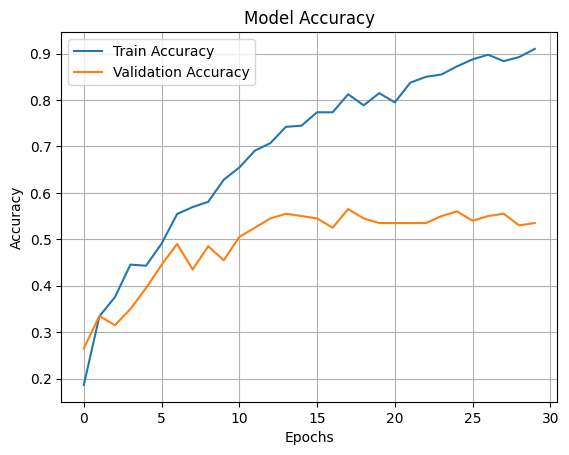

In [10]:
import matplotlib.pyplot as plt

# Plotting accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


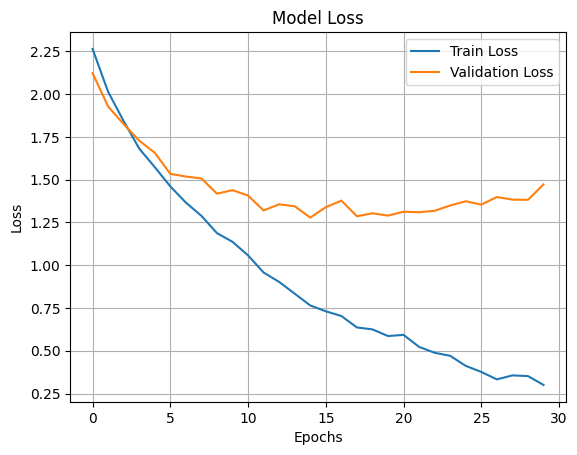

In [11]:
# Plotting loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
              precision    recall  f1-score   support

       blues       0.38      0.24      0.29        21
   classical       0.86      1.00      0.92        12
     country       0.42      0.42      0.42        24
       disco       0.82      0.41      0.55        22
      hiphop       0.45      0.67      0.54        15
        jazz       0.81      0.63      0.71        27
       metal       0.61      0.78      0.68        18
         pop       0.71      0.63      0.67        19
      reggae       0.57      0.59      0.58        22
        rock       0.16      0.25      0.19        20

    accuracy                           0.54       200
   macro avg       0.58      0.56      0.55       200
weighted avg       0.57      0.54      0.54       200



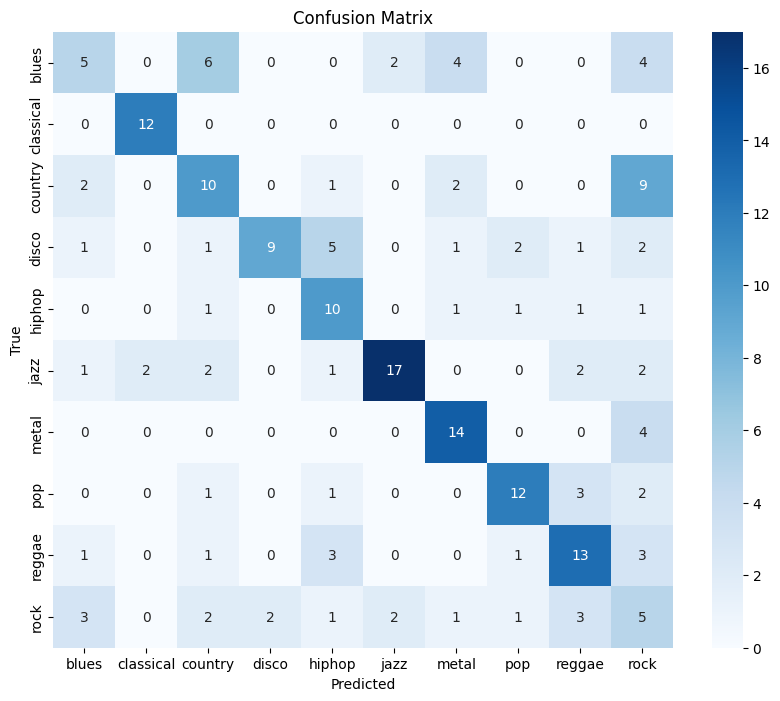

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_true_labels, y_pred_labels, target_names=encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=encoder.classes_, yticklabels=encoder.classes_, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [14]:
# Save entire model (architecture + weights + optimize
model.save("music_classification_lstm.keras")


In [15]:
import os
import librosa
import numpy as np
import pandas as pd

DATASET_PATH = '/content/drive/MyDrive/genres_original'
GENRES = os.listdir(DATASET_PATH)

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=22050, duration=30)

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
    zcr = librosa.feature.zero_crossing_rate(y)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    rms = librosa.feature.rms(y=y)
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)

    # For each feature, we compute mean and std deviation
    features = {
        'mfcc_mean': np.mean(mfcc),
        'mfcc_std': np.std(mfcc),
        'delta_mean': np.mean(mfcc_delta),
        'delta_std': np.std(mfcc_delta),
        'delta2_mean': np.mean(mfcc_delta2),
        'delta2_std': np.std(mfcc_delta2),
        'zcr_mean': np.mean(zcr),
        'zcr_std': np.std(zcr),
        'chroma_mean': np.mean(chroma),
        'chroma_std': np.std(chroma),
        'rms_mean': np.mean(rms),
        'rms_std': np.std(rms),
        'spectral_centroid_mean': np.mean(spectral_centroid),
        'spectral_centroid_std': np.std(spectral_centroid),
        'spectral_bandwidth_mean': np.mean(spectral_bandwidth),
        'spectral_bandwidth_std': np.std(spectral_bandwidth),
    }

    return features

# Create matrix for each file
feature_matrix = []

for genre in GENRES:
    genre_path = os.path.join(DATASET_PATH, genre)
    files = [f for f in os.listdir(genre_path) if f.endswith('.wav')][:10]  # Only 10 files per genre
    for file in files:
        try:
            file_path = os.path.join(genre_path, file)
            features = extract_features(file_path)
            features['genre'] = genre
            features['filename'] = file
            feature_matrix.append(features)
        except Exception as e:
            print(f"❌ Failed on {file}: {e}")

# Convert to DataFrame
df_features = pd.DataFrame(feature_matrix)

# Save to CSV for inspection
df_features.to_csv('/content/audio_features_summary.csv', index=False)

df_features.head()



,mfcc_mean,mfcc_std,delta_mean,delta_std,delta2_mean,delta2_std,zcr_mean,zcr_std,chroma_mean,chroma_std,rms_mean,rms_std,spectral_centroid_mean,spectral_centroid_std,spectral_bandwidth_mean,spectral_bandwidth_std,genre,filename
0,-9.650855,63.250591,0.010851,4.166235,-0.002998,2.307221,0.101500,0.044199,0.308598,0.296396,0.091540,0.048011,1835.507008,585.947299,1748.367477,297.422362,blues,blues.00004.wav
1,3.117406,51.817871,0.005619,3.360462,-0.003443,1.886466,0.083066,0.027690,0.349951,0.297913,0.130192,0.053201,1784.416546,360.194166,2002.657106,292.966459,blues,blues.00000.wav
2,3.361415,52.996368,0.001285,3.964326,-0.000321,2.420022,0.076301,0.031738,0.363562,0.292023,0.175494,0.052465,1552.637786,395.649207,1747.382028,275.954142,blues,blues.00002.wav
3,-8.226527,68.218658,0.005803,4.729036,0.005327,2.589996,0.094040,0.078976,0.302414,0.295909,0.103438,0.063117,1831.990069,1015.527254,1729.456259,449.443888,blues,blues.00005.wav
4,0.878578,73.835556,-0.014597,4.339016,-0.000148,2.219538,0.033309,0.020569,0.404848,0.306623,0.141139,0.079623,1070.110059,429.542379,1596.244204,408.212651,blues,blues.00003.wav


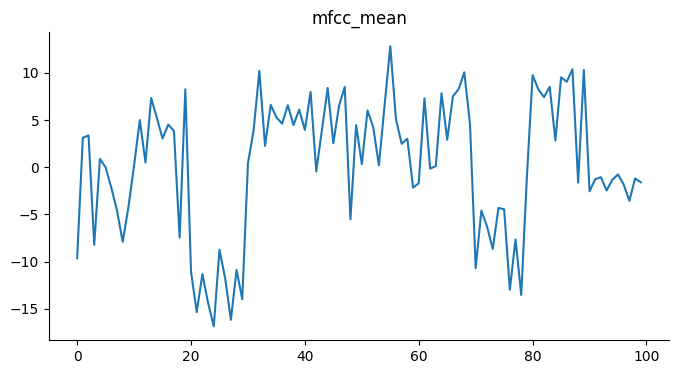

In [16]:
from matplotlib import pyplot as plt
df_features['mfcc_mean'].plot(kind='line', figsize=(8, 4), title='mfcc_mean')
plt.gca().spines[['top', 'right']].set_visible(False)

🎵 Genre: jazz
📁 File: jazz.00001.wav


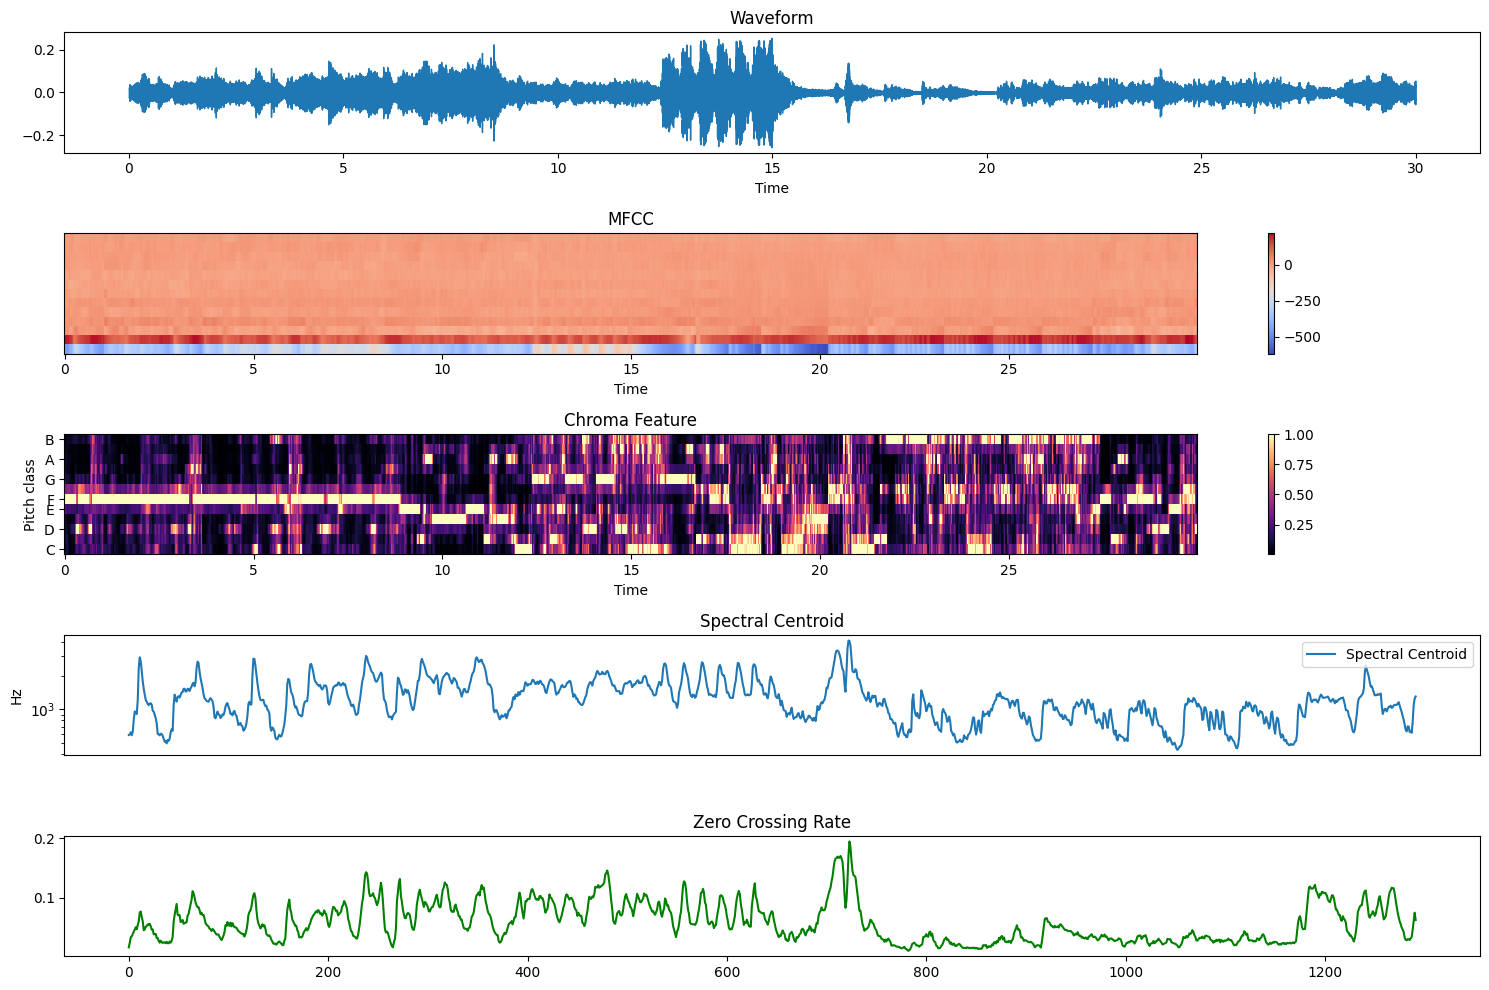

In [17]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
import IPython.display as ipd

# Path to dataset
DATASET_PATH = '/content/drive/MyDrive/genres_original'
GENRE = 'jazz'  # Example genre
FILENAME = 'jazz.00001.wav'  # Example file
file_path = os.path.join(DATASET_PATH, GENRE, FILENAME)

# Load audio
y, sr = librosa.load(file_path, sr=22050, duration=30)

# Display genre
print(f"🎵 Genre: {GENRE}")
print(f"📁 File: {FILENAME}")

# Play audio (for Colab or Jupyter)
ipd.display(ipd.Audio(y, rate=sr))

# Extract features
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
chroma = librosa.feature.chroma_stft(y=y, sr=sr)
spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
zcr = librosa.feature.zero_crossing_rate(y)

# Plot all features
plt.figure(figsize=(15, 10))

# Waveform
plt.subplot(5, 1, 1)
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')

# MFCC
plt.subplot(5, 1, 2)
librosa.display.specshow(mfcc, x_axis='time', sr=sr)
plt.colorbar()
plt.title('MFCC')

# Chroma
plt.subplot(5, 1, 3)
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', sr=sr)
plt.colorbar()
plt.title('Chroma Feature')

# Spectral Centroid
plt.subplot(5, 1, 4)
frames = range(len(spectral_centroid[0]))
t = librosa.frames_to_time(frames, sr=sr)
plt.semilogy(t, spectral_centroid[0], label='Spectral Centroid')
plt.ylabel('Hz')
plt.xticks([])
plt.legend(loc='upper right')
plt.title('Spectral Centroid')

# Zero Crossing Rate
plt.subplot(5, 1, 5)
plt.plot(zcr[0], color='g')
plt.title('Zero Crossing Rate')
plt.tight_layout()
plt.show()
